In [1]:
import collections
import dataclasses

import networkx as nx
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns

from scripture_graph import graph_lib

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
graph = nx.read_graphml('../../scripture_graph.graphml')

In [3]:
nx.reciprocity(graph)

0.824880967981479

In [4]:
print(nx.info(graph))

Name: 
Type: DiGraph
Number of nodes: 41995
Number of edges: 45786
Average in degree:   1.0903
Average out degree:   1.0903


In [5]:
print(nx.number_weakly_connected_components(graph))
print(nx.number_strongly_connected_components(graph))

24015
26773


# Weakly Connected Components

In [6]:
sizes = []
for component in nx.weakly_connected_components(graph):
    sizes.append(len(component))
sizes = np.asarray(sizes)

x = np.unique(sizes)
y = np.asarray([np.count_nonzero(sizes == size) for size in x])
df = pd.DataFrame({'size': x, 'count': y})
df

,size,count
0,1,22250
1,2,1161
2,3,342
3,4,124
4,5,64
5,6,23
6,7,12
7,8,15
8,9,7
9,10,7


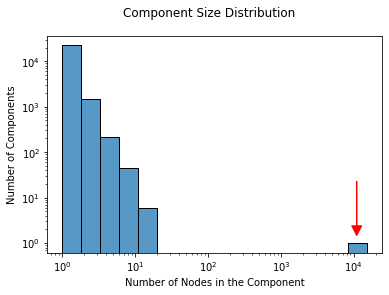

In [7]:
fig, ax = subplots()
sns.histplot(sizes, log_scale=True, ax=ax)
ax.set_yscale('log')
ax.set_ylabel('Number of Components')
ax.set_xlabel('Number of Nodes in the Component')
fig.suptitle('Component Size Distribution')
# Add an arrow.
ax.arrow(0.925, 0.33, 0, -0.25, transform=ax.transAxes, head_width=0.03, color='red', length_includes_head=True)
fig.savefig('component-size.png', dpi=300, bbox_inches='tight')

In [8]:
# Prune the graph to the largest strongly connected component.
# How many edges does it have?
nodes = None
for component in nx.weakly_connected_components(graph):
    if len(component) > 1000:
        nodes = component
        break
subgraph = nx.subgraph(graph, nodes)
print(graph.number_of_nodes())
print(graph.number_of_edges())
print(subgraph.number_of_nodes())
print(subgraph.number_of_edges())

41995
45786
14988
39816


In [9]:
# Percentage of singletons (no incoming *or* outgoing edges)
count = 0
for node, degree in graph.degree():
    if degree == 0:
        count += 1
print(count, count / graph.number_of_nodes())

22250 0.5298249791641862


In [10]:
# Percentage of non-singletons in the largest component.
subgraph.number_of_nodes() / count

0.6736179775280899

# Centrality

In [11]:
def assign_ranks(scores):
    rows = []
    for key, value in scores.items():
        rows.append({'verse': key, 'score': value})
    df = pd.DataFrame(rows)
    df['rank'] = scipy.stats.rankdata(-1 * df.score.values, method='min')
    return df.sort_values(['rank', 'verse'], ignore_index=True)

In [12]:
degree_df = assign_ranks(nx.in_degree_centrality(subgraph))
degree_df.head(10)

,verse,score,rank
0,D&C 17:1,0.001802,1
1,D&C 1:38,0.001802,1
2,1 Ne. 17:35,0.001668,3
3,Hel. 12:3,0.001668,3
4,D&C 1:14,0.001601,5
5,1 Ne. 19:10,0.001535,6
6,2 Ne. 25:20,0.001535,6
7,Moses 6:57,0.001535,6
8,D&C 1:16,0.001401,9
9,D&C 88:63,0.001401,9


In [13]:
pagerank_df = assign_ranks(nx.pagerank(subgraph))
pagerank_df.head(10)

,verse,score,rank
0,D&C 1:38,0.000575,1
1,1 Ne. 17:35,0.000563,2
2,Mosiah 4:26,0.000554,3
3,Hel. 12:3,0.000520,4
4,2 Ne. 9:37,0.000485,5
5,2 Ne. 9:28,0.000479,6
6,D&C 1:14,0.000472,7
7,D&C 17:1,0.000460,8
8,D&C 88:63,0.000460,9
9,Moses 6:57,0.000455,10


In [14]:
merged = degree_df.merge(pagerank_df, on='verse', suffixes=('_degree', '_pagerank'))
assert len(merged) == len(degree_df) == len(pagerank_df)
merged['in_degree'] = [subgraph.in_degree(verse) for verse in merged.verse.values]
merged['out_degree'] = [subgraph.out_degree(verse) for verse in merged.verse.values]
merged.head()

,verse,score_degree,rank_degree,score_pagerank,rank_pagerank,in_degree,out_degree
0,D&C 17:1,0.001802,1,0.000460,8,27,19
1,D&C 1:38,0.001802,1,0.000575,1,27,19
2,1 Ne. 17:35,0.001668,3,0.000563,2,25,17
3,Hel. 12:3,0.001668,3,0.000520,4,25,9
4,D&C 1:14,0.001601,5,0.000472,7,24,16


In [15]:
# Calculate the rank correlation; we don't necessarily expect/need the relationship to be linear (i.e. pearson)
t, _ = scipy.stats.kendalltau(merged.score_degree.values, merged.score_pagerank.values)
r, _ = scipy.stats.spearmanr(merged.score_degree.values, merged.score_pagerank.values)
print(t, r**2)

0.7274002305893602 0.7403013598462614


In [16]:
merged[merged.verse.isin(['2 Ne. 9:37', '2 Ne. 9:28'])]

,verse,score_degree,rank_degree,score_pagerank,rank_pagerank,in_degree,out_degree
10,2 Ne. 9:28,0.001334,11,0.000479,6,20,20
120,2 Ne. 9:37,0.000801,110,0.000485,5,12,1


In [17]:
neighbors = [source for source, _ in subgraph.in_edges('2 Ne. 9:37')]
df = merged[merged.verse.isin(neighbors)]
print(sum(df.score_pagerank / df.out_degree))
df

0.0006024807288538964


,verse,score_degree,rank_degree,score_pagerank,rank_pagerank,in_degree,out_degree
350,Alma 7:6,0.000601,318,0.000126,1575,9,3
2013,Hel. 6:31,0.000334,1470,0.000102,2727,5,6
2965,Deut. 31:16,0.000267,2319,0.000096,3079,4,6
3352,Judg. 2:17,0.000267,2319,0.000083,4137,4,6
4197,Alma 31:1,0.000200,3676,0.000061,6581,3,4
4818,Ex. 34:14,0.000200,3676,0.000054,7511,3,6
4845,Ezek. 18:6,0.000200,3676,0.000095,3180,3,4
12186,Isa. 41:24,0.000067,9339,0.000438,11,1,1
12784,Lev. 19:4,0.000067,9339,0.000020,13589,1,3
13677,Ps. 16:4,0.000067,9339,0.000019,13689,1,5


In [18]:
neighbors = [source for source, _ in subgraph.in_edges('2 Ne. 9:28')]
df = merged[merged.verse.isin(neighbors)]
print(sum(df.score_pagerank / df.out_degree))
df

0.0005510264529943013


,verse,score_degree,rank_degree,score_pagerank,rank_pagerank,in_degree,out_degree
56,2 Ne. 26:20,0.000934,56,0.000240,133,14,17
174,2 Ne. 19:17,0.000734,167,0.000184,434,11,9
289,Jacob 4:10,0.000667,223,0.000209,258,10,6
1062,Alma 37:12,0.000400,930,0.000141,1121,6,6
1789,D&C 35:7,0.000334,1470,0.000115,2022,5,5
2984,Eccl. 10:12,0.000267,2319,0.000095,3158,4,4
3571,Prov. 14:6,0.000267,2319,0.000093,3312,4,4
3572,Prov. 15:22,0.000267,2319,0.000107,2403,4,5
3947,2 Ne. 28:4,0.000200,3676,0.000073,5103,3,3
4582,D&C 76:9,0.000200,3676,0.000103,2641,3,2


# Hubs and Authorities

In [19]:
hubs, authorities = nx.hits(subgraph, max_iter=1000)

In [20]:
assign_ranks(hubs).head(10)

,verse,score,rank
0,1 Ne. 19:10,0.036332,1
1,2 Ne. 26:12,0.015242,2
2,Mosiah 7:19,0.010363,3
3,D&C 8:3,0.009782,4
4,2 Ne. 19:6,0.009092,5
5,1 Ne. 17:26,0.008458,6
6,Ex. 3:10,0.008108,7
7,Moro. 7:22,0.008100,8
8,2 Ne. 10:3,0.007759,9
9,2 Ne. 25:20,0.007706,10


In [21]:
assign_ranks(authorities).head(10)

,verse,score,rank
0,Mosiah 7:19,0.018702,1
1,1 Ne. 19:10,0.015089,2
2,2 Ne. 25:20,0.014996,3
3,Mosiah 7:27,0.014096,4
4,2 Ne. 26:12,0.012079,5
5,2 Ne. 10:3,0.011668,6
6,Alma 11:39,0.011661,7
7,3 Ne. 11:14,0.010627,8
8,Ex. 3:10,0.009822,9
9,Mosiah 27:31,0.009045,10
